# Predittore - fast implementation

Asvestis' solution for #EUvsVirus Hackathon 

## Introduction

Research notebook for prediction models.

We need dataclasses, pandas

In [18]:
from dataclasses import dataclass
import pandas as pd
import json

@dataclass
class Values:
    def __init__(self, value: pd.DataFrame):
        self.value = value
        self.value_ma = self.value.rolling(window=7).mean()

    def get(self):
        return {
            'Raw': self.value.fillna(0).to_dict(),
            'Moving Average 7 days': self.value_ma.fillna(0).to_dict()
        }

@dataclass
class Measurement:
    def __init__(self, measurement: pd.DataFrame):
        self.measurement = Values(measurement)
        self.measurement_diff = Values(measurement.diff())

    def get(self):
        return {
            'Cumulative': self.measurement.get(),
            'Daily new': self.measurement_diff.get()
        }

@dataclass
class COVID19:
    def __init__(self, confirmed: pd.DataFrame, deaths: pd.DataFrame, recovered: pd.DataFrame):
        self.confirmed = Measurement(confirmed)
        self.deaths = Measurement(deaths)
        self.recovered = Measurement(recovered)

    def to_json(self):
        return json.dmps({
            'confirmed': self.confirmed.get(),
            'deaths': self.deaths.get(),
            'recovered': self.recovered.get()
        })

Load up the data from the COVID-19 submodule

In [19]:
import os

# Get the base folder relatively to COVID-19
base_folder = os.path.join('..', 'COVID-19', 'csse_covid_19_data', 'csse_covid_19_time_series')

confirmed = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_confirmed_global.csv'), sep=',')
deaths = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_deaths_global.csv'), sep=',')
recovered = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_recovered_global.csv'), sep=',')
confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,840,906,933,996,1026,1092,1176,1279,1351,1463
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,518,539,548,562,584,609,634,663,678,712
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,673,696,704,713,717,717,723,723,731,738
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,19,19,24,24,24,24,25,25,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,4,4,4,4,4,4,4,5,5,5
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


We wrote a little function to extract data 

In [20]:
import calendar
import datetime

def makeComputations(countries):
    global base_folder

    confirmed = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_confirmed_global.csv'), sep=',')
    deaths = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_deaths_global.csv'), sep=',')
    recovered = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_recovered_global.csv'), sep=',')

    get_total_per_country = lambda df: df.sum(axis=0) if not df.isnull().values.any() else df[df.isna().any(axis=1)]
    # clean_date = lambda df: df.set_index(pd.Index([datetime.date(2000 + int(dd.split('/')[2]), int(dd.split('/')[0]), int(dd.split('/')[1])) for dd in list(df.index.values)]))
    clean_date = lambda df: df.set_index(pd.Index([calendar.timegm(datetime.date(2000 + int(dd.split('/')[2]), int(dd.split('/')[0]), int(dd.split('/')[1])).timetuple()) for dd in list(df.index.values)]))

    # countries = [k for k, _ in countries.items()]

    objs = []
    for obj in [confirmed, deaths, recovered]:
        dfs = []
        for c in countries:
            total = get_total_per_country(obj[obj['Country/Region'] == c])
            if isinstance(total, pd.core.frame.Series):
                total = pd.DataFrame(total)
                total = total.transpose()
            total = total.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
            total = total.set_index(pd.Index(['Total ' + c]))
            total = total.transpose()
            total = clean_date(total)
            dfs.append(total)
        objs.append(pd.concat(dfs, axis=1, sort=False))

    selected = COVID19(objs[0], objs[1], objs[2])

    return selected

all_countries = makeComputations(confirmed['Country/Region'].drop_duplicates())

## Logistic regression

We use the following relationship

$$
y(x) = \frac{A}{1 - e^{-k \cdot (x - x_0)}} + B
$$

- $[A, k, x_0, B] \in \mathbb{R}$
- $y \in \{confirmed, deaths, recovered\}$

In [21]:
import numpy as np
from scipy.optimize import curve_fit

In [22]:
def logisticRegression(x, y, forward=7 * 48):
    sigmoid = lambda x, A, B, k, x0: A / (1 + np.exp(-k*(x-x0)))+B

    popt, pcov = curve_fit(sigmoid, x, y)

    return sigmoid(range(len(x) + forward), *popt), pcov

## Gaussian regression

We use the following function:

$$
y(t) = A \times e^{\frac{-(t - t_0)^2}{2 \cdot \sigma^2}}
$$

- $[A, x_0, \sigma] \in \mathbb{R}$
- $y \in \{confirmed, deaths, recovered\}$

In [23]:
def gaussRegression(x ,y, forward=7 * 48):
    gauss = lambda x, a, x0, sigma: a*np.exp(-(x-x0)**2/(2*sigma**2))

    popt, pcov = curve_fit(gauss, x, y)

    return gauss(range(len(x) + forward), *popt), pcov

## Use case

For accessing data we must use either the *all_countries* variable

The data tree is the following:

```
all_countries
|
--- confirmed
|   |
|    --- measurement (raw CUMULATIVE data from John Hopkins)
|        |
|        --- value (the measurement raw value)
|        --- value_ma (moving average measurement)
|
|    --- measurement_diff (derivate of raw cumulative data from John Hopkins)
|        |
|        --- value (the measurement_diff computed value)
|        --- value_ma (moving average of measurement derivate computed value)
--- deaths
|
|
|
--- recovered
```

Same logic applies to deaths and recovered

In [24]:
countries = ['US']

for country in countries:
    confirmed_cumulative_raw = all_countries.confirmed.measurement.value[f'Total {country}']
    confirmed_cumulative_moving_average = all_countries.confirmed.measurement.value_ma[f'Total {country}']
    
    confirmed_derivate_raw = all_countries.confirmed.measurement_diff.value[f'Total {country}']
    confirmed_derivate_moving_average = all_countries.confirmed.measurement_diff.value_ma[f'Total {country}']

print(confirmed_cumulative_raw)

1579651200         1
1579737600         1
1579824000         2
1579910400         2
1579996800         5
               ...  
1587427200    811865
1587513600    840351
1587600000    869170
1587686400    905358
1587772800    938154
Name: Total US, Length: 95, dtype: int64


In [25]:
print(confirmed_cumulative_moving_average)

1579651200              NaN
1579737600              NaN
1579824000              NaN
1579910400              NaN
1579996800              NaN
                  ...      
1587427200    727263.571429
1587513600    756406.571429
1587600000    785203.428571
1587686400    814582.285714
1587772800    844004.714286
Name: Total US, Length: 95, dtype: float64


<module 'matplotlib.pyplot' from '/home/redeye/miniconda3/envs/bio/lib/python3.8/site-packages/matplotlib/pyplot.py'>

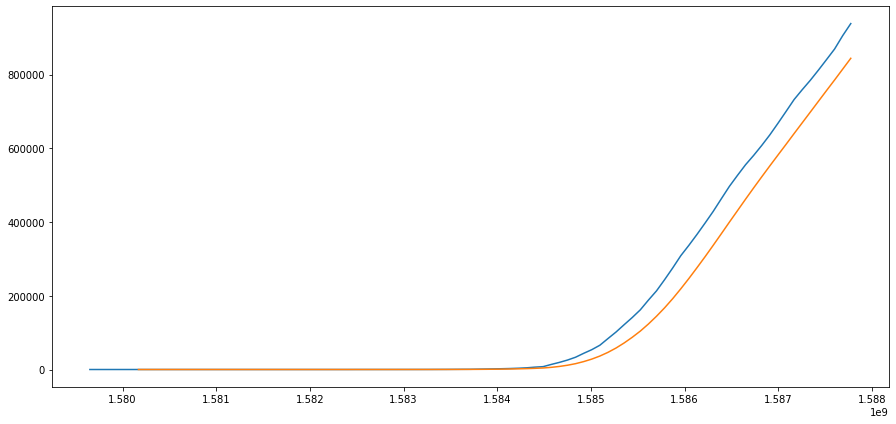

In [26]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 7)

plt.plot(confirmed_cumulative_raw)
plt.plot(confirmed_cumulative_moving_average)
plt

<module 'matplotlib.pyplot' from '/home/redeye/miniconda3/envs/bio/lib/python3.8/site-packages/matplotlib/pyplot.py'>

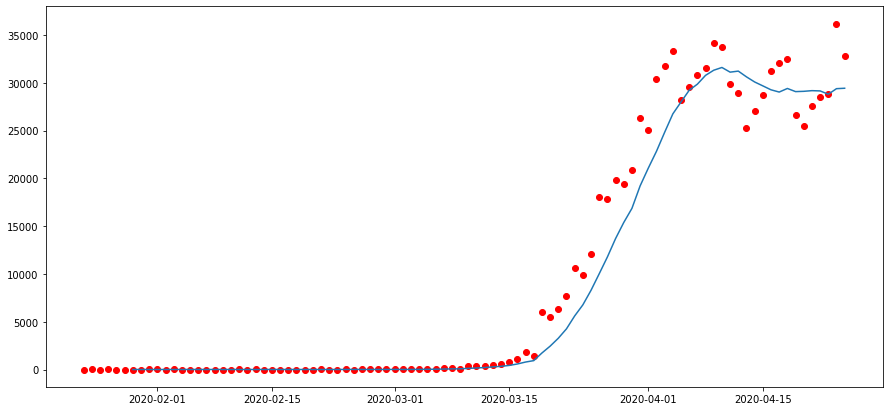

In [27]:
plt.scatter(list(map(datetime.date.fromtimestamp, confirmed_derivate_raw.index.values)), confirmed_derivate_raw.values, c='r')
plt.plot(list(map(datetime.date.fromtimestamp, confirmed_derivate_raw.index.values)), confirmed_derivate_moving_average.values)
plt

### Derivate regression

Looks like a gaussian function:

[[ 2.61068959e+05 -2.88994955e+01  9.99296546e+01]
 [-2.88994955e+01  1.37882681e-01 -9.03555902e-02]
 [ 9.99296546e+01 -9.03555902e-02  1.46411224e-01]]


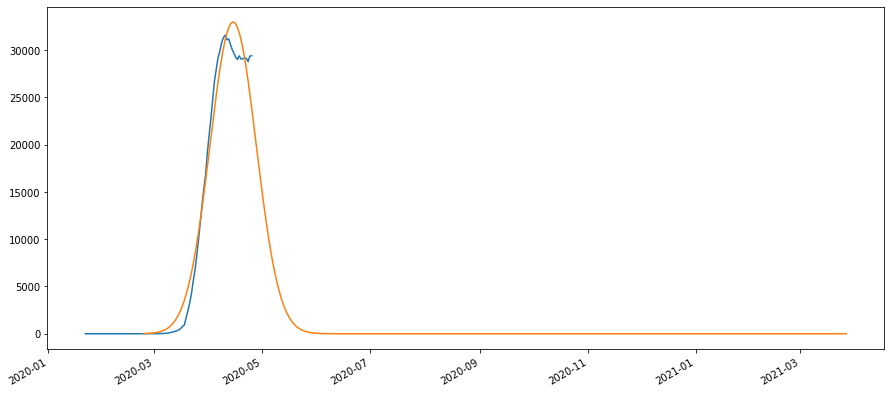

In [28]:
df = confirmed_derivate_moving_average.fillna(0)
x = list(map(datetime.date.fromtimestamp, df.index.values))
y = df.values

xs = np.where(y > 5)[0][0]
ydata = y[xs:]
xdata = np.arange(ydata.shape[0])

res, cov = gaussRegression(xdata, ydata)
print(cov)
forward_date = [(x[xs] + datetime.timedelta(days=i)) for i in range(len(res))]

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(x, y)
ax.plot(forward_date, res)
plt.show()
# plt.savefig('gaussian.png')

We can evaluate the theorical end of lockdown when 0 new cases are reported

In [29]:
zero_new_case = np.where(res[:res.shape[0] // 2] < 1)[0][0]
lockdown_end = forward_date[zero_new_case]
print(lockdown_end)

2020-06-14


16
0.6729584512010685


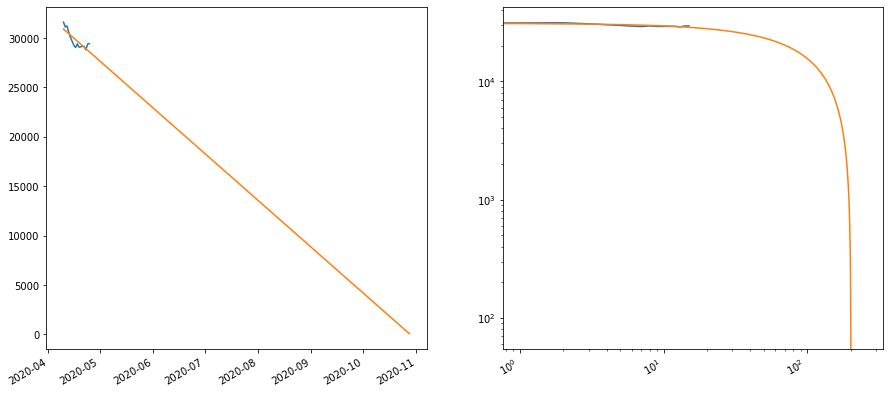

In [30]:
from sklearn.linear_model import LinearRegression

print(y.shape[0] - y.argmax())

X = np.array(range(y.shape[0] - y.argmax())).reshape(-1, 1)
Y = y[y.argmax():len(x)]

linearRegression = LinearRegression()
linearRegression.fit(X, Y)

print(linearRegression.score(X, Y))

forward = linearRegression.predict(np.arange(7 * 48 - y.argmax()).reshape(-1, 1))
end_forward = np.where(forward < 0)[0][0]

fig, axs = plt.subplots(ncols=2, nrows=1)
fig.autofmt_xdate()
axs[0].plot([(x[y.argmax()] + datetime.timedelta(days=i)) for i in range(len(Y))], Y, [(x[y.argmax()] + datetime.timedelta(days=i)) for i in range(end_forward)], forward[:end_forward])
axs[1].loglog(X, Y, forward)

In [31]:
zero_new_case = np.where(forward < 0)[0][0]
lockdown_end = forward_date[y.argmax() + zero_new_case]
print(lockdown_end)

2020-12-01


### Cumulative regression

This looks like a sigmoid curve:

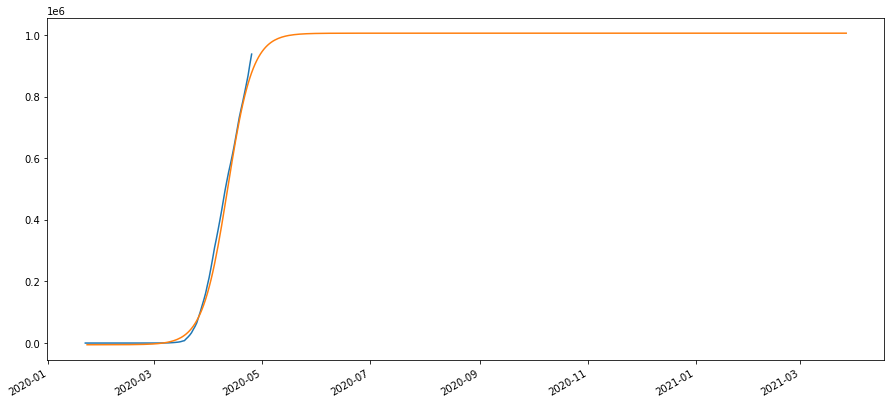

In [32]:
df = confirmed_cumulative_raw.fillna(0)
x = list(map(datetime.date.fromtimestamp, df.index.values))
y = df.values

xd = list(map(lambda x: x.days, np.array(x) - x[0]))

xs = np.where(np.array(xd) > 0)[0][0]
backward_lookup = 0
# xs = 20

xdata = xd[xs - backward_lookup:]
ydata = y[xs - backward_lookup:]

res, cov = logisticRegression(xdata, ydata)
forward_date = [(x[xs] + datetime.timedelta(days=i)) for i in range(len(res))]

fig, ax = plt.subplots()
fig.autofmt_xdate()
plt.plot(x, y)
plt.plot(forward_date, res)
plt.show()
# plt.savefig('sigmoid.png')

In [33]:
zero_new_case = np.where(np.diff(res[:res.shape[0] // 2]) < 1)[0][0]
lockdown_end = forward_date[zero_new_case]
print(lockdown_end)

2020-07-04
